In [1]:
%matplotlib inline


nn.Transformer 와 TorchText 로 시퀀스-투-시퀀스(Sequence-to-Sequence) 모델링하기
==========================================================================

이 튜토리얼에서는
`nn.Transformer`모듈을
이용하는 시퀀스-투-시퀀스(Sequence-to-Sequence) 모델을 학습하는 방법을 배워보겠습니다.

PyTorch 1.2 버젼에는
`Attention is All You Need` 논문에
기반한 표준 트랜스포머(transformer) 모듈을 포함하고 있습니다.
트랜스포머 모델은 더 높은 수준의 병렬화(parallelization)가 가능하면서도
많은 시퀀스-투-시퀀스 문제들에서 품질이 우수함이 입증되었습니다.
``nn.Transformer`` 모듈은 입력(input) 과 출력(output) 사이의 전역적인 의존성(global dependencies)
을 나타내기 위하여 전적으로 어텐션(attention) 메커니즘에 의존합니다.
(최근에 또 다른 모듈이 `nn.MultiheadAttention` 으로 구현되었습니다.)
``nn.Transformer`` 모듈은 현재 모듈화가 매우 잘 되어 있어,
다음과 같은 단일 컴포넌트 (이 튜토리얼의 `nn.TransformerEncoder`__ 와 같은)
는 쉽게 적용 및 구성될 수 있습니다.



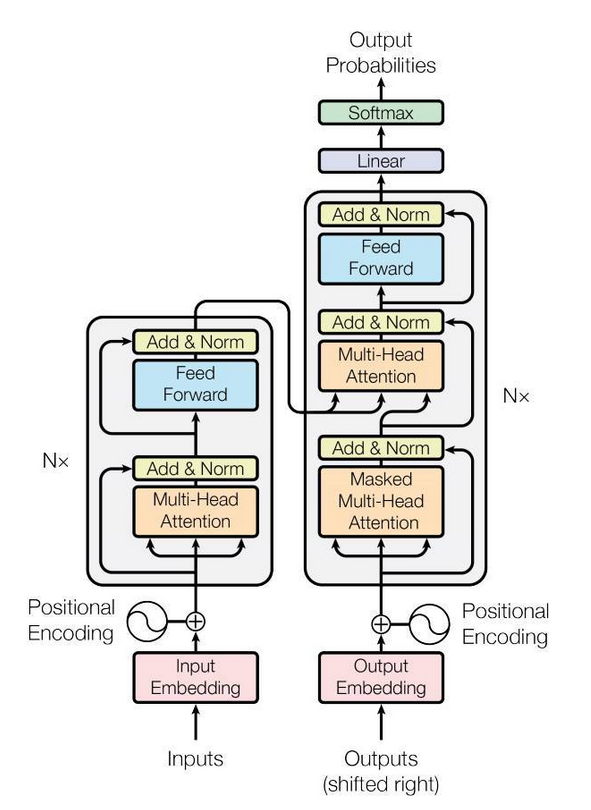

모델 정의하기
----------------




이 튜토리얼에서, 우리는 ``nn.TransformerEncoder`` 모델을 언어 모델링(language modeling) 과제에 대해서 학습시킬 것입니다.
언어 모델링 과제는 주어진 단어 (또는 단어의 시퀀스) 가 다음에 이어지는 단어 시퀀스를 따를 가능성(likelihood)에 대한 확률을 할당하는 것입니다.
먼저, 토큰(token) 들의 시퀀스가 임베딩(embedding) 레이어로 전달되며, 이어서 포지셔널 인코딩(positional encoding) 레이어가 각 단어의 순서를 설명합니다.
(더 자세한 설명은 다음 단락을 참고해주세요.)
``nn.TransformerEncoder`` 는 여러 개의
`nn.TransformerEncoderLayer`
레이어로 구성되어 있습니다.
``nn.TransformerEncoder`` 내부의 셀프-어텐션(self-attention) 레이어들은 시퀀스 안에서의 이전 포지션에만 집중하도록 허용되기 때문에,
입력(input) 순서와 함께, 정사각 형태의 어텐션 마스크(attention mask) 가 필요합니다.
언어 모델링 과제를 위해서, 미래의 포지션에 있는 모든 토큰들은 마스킹 되어야(가려져야) 합니다.
실제 단어를 얻기 위해서, ``nn.TransformerEncoder`` 의 출력은 로그-소프트맥스(log-Softmax) 로 이어지는 최종 선형(Linear) 레이어로 전달 됩니다.




In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

<b> torch.nn.TransformerEncoderLayer</b>(d_model, nhead, dim_feedforward=2048, dropout=0.1, activation='relu')
- d_model – the number of expected features in the input (required).
- nhead – the number of heads in the multiheadattention models (required).
- dim_feedforward – the dimension of the feedforward network model (default=2048).
- dropout – the dropout value (default=0.1).
- activation – the activation function of intermediate layer, relu or gelu (default=relu).

<b>torch.nn.TransformerEncoder</b>(*encoder_layer, num_layers, norm=None*)<br>
: stack of N encoder layers
- encoder_layer – an instance of the TransformerEncoderLayer() class (required).
- num_layers – the number of sub-encoder-layers in the encoder (required).
- norm – the layer normalization component (optional).<br>
forward(*src: torch.Tensor, mask, src_key_padding_mask*)
- src – the sequence to the encoder (required).
- mask – the mask for the src sequence (optional).
- src_key_padding_mask – the mask for the src keys per batch (optional).

In [5]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        # ntoken : the number of tokens in sequence 
        # ninp : the number of expected features in the input
        # nhead : the number of heads in multi-head attention model 
        # nhid : the dimension of the feedforward network model 
        # nlayers : the number of sub-encoder-layers in the encoder
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        # encoder의 nn.Embedding의 레이어 초기화
        self.encoder.weight.data.uniform_(-initrange, initrange)
        # decoder의 Fully Connected layer 초기화
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

``PositionalEncoding`` 모듈은 시퀀스 안에서 토큰의 상대적인 또는 절대적인 포지션에 대한 어떤 정보를 주입합니다.
포지셔널 인코딩은 임베딩과 합칠 수 있도록 똑같은 차원을 가집니다.
여기에서, 우리는 다른 주파수(frequency) 의 ``sine`` 과 ``cosine`` 함수를 사용합니다.




데이터 로드하고 배치 만들기
-------------------




학습 과정에서는 ``torchtext`` 의 Wikitext-2 데이터셋을 이용합니다.
단어 오브젝트는 훈련 데이터셋(train dataset) 에 의하여 만들어지고, 토큰을 텐서(tensor)로 수치화하는데 사용됩니다.
시퀀스 데이터로부터 시작하여, ``batchify()`` 함수는 데이터셋을 컬럼들로 배열하고, ``batch_size`` 사이즈의 배치들로 나눈 후에 남은 모든 토큰을 버립니다.
예를 들어, 알파벳을 시퀀스(총 길이 26) 로 생각하고 배치 사이즈를 4라고 한다면, 우리는 알파벳을 길이가 6인 4개의 시퀀스로 나눌 수 있습니다.

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

이 컬럼들은 모델에 의해서 독립적으로 취급되며, 이것은 더 효율적인 배치 프로세싱(batch processing) 이 가능하지만, ``G`` 와 ``F`` 의 의존성이 학습될 수 없다는 것을 의미합니다.




In [6]:
import torchtext
from torchtext.data.utils import get_tokenizer

In [14]:
TEXT = torchtext.data.Field(tokenize=get_tokenizer("basic_english"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)
train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
def batchify(data, bsz):
    data = TEXT.numericalize([data.examples[0].text])
    # 데이터셋을 bsz 파트들로 나눕니다.
    nbatch = data.size(0) // bsz
    # 깔끔하게 나누어 떨어지지 않는 추가적인 부분(나머지들) 은 잘라냅니다.
    data = data.narrow(0, 0, nbatch * bsz)
    # 데이터에 대하여 bsz 배치들로 동등하게 나눕니다.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

In [7]:
batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:02<00:00, 1.49MB/s]


extracting


/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


입력(input) 과 타겟(target) 시퀀스를 생성하기 위한 함수들

``get_batch()`` 함수는 트랜스포머 모델을 위한 입력과 타겟 시퀀스를 생성합니다.
이 함수는 소스 데이터를 ``bptt`` 길이를 가진 덩어리로 세분화 합니다.
언어 모델링 과제를 위해서, 모델은 다음 단어인 ``Target`` 이 필요 합니다.
예를 들어, ``bptt`` 의 값이 2 라면, 우리는 i = 0 일 때(첫번째 토큰일 때,) 다음의 2 개의 변수(Variable) 를 얻을 수 있습니다:

![](../_static/img/transformer_input_target.png)


변수 덩어리는 트랜스포머 모델의 ``S`` 차원과 일치하는 0 차원에 해당합니다.
배치 차원 ``N`` 은 1 차원에 해당합니다.




In [8]:
bptt = 35 # max_seq
def get_batch(source, i):
    seq_len = min(bptt,일 때 len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

인스턴스(instance) 초기화하기
--------------------




모델은 아래와 같은 하이퍼파라미터(hyperparameter) 로 세팅 됩니다.
단어 사이즈는 단어 오브젝트의 길이와 일치 합니다.




In [9]:
ntokens = len(TEXT.vocab.stoi) # 단어 사전의 크기
emsize = 200 # 임베딩 차원
nhid = 200 # nn.TransformerEncoder 에서 피드포워드 네트워크(feedforward network) 모델의 차원
nlayers = 2 # nn.TransformerEncoder 내부의 nn.TransformerEncoderLayer 개수
nhead = 2 # 멀티헤드 어텐션(multi-head attention) 모델의 헤드 개수
dropout = 0.2 # 드랍아웃(dropout) 값
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

모델 실행하기
-------------

손실(loss) 을 추적하는 데에는
`CrossEntropyLoss`가 적용되며, 옵티마이저(optimizer) 로서
`SGD`는 확률적 경사 하강법(stochastic gradient descent method) 을 구현합니다.
초기 학습률(learning rate) 은 5.0 으로 설정됩니다.
`StepLR`
은 에포크(epoch) 에 따라서 학습률을 조절하는데 사용됩니다.
학습하는 동안에, 우리는 기울기 폭발(gradient exploding) 을 방지하기 위하여 모든 기울기를 함께 스케일(scale) 하는 함수인
`nn.utils.clip_grad_norm`
을 이용합니다.

In [10]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # 학습률
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [11]:
import time
def train():
    model.train() # 학습 모드를 시작합니다.
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # 평가 모드를 시작합니다.
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output = eval_model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

에포크 내에서 반복됩니다. 만약 검증 오차(validation loss) 가 우리가 지금까지 관찰한 것 중 최적이라면 모델을 저장합니다.
매 에포크 이후에 학습률을 조절합니다.



In [12]:
best_val_loss = float("inf")
epochs = 3 # 에포크 수
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |   200/ 2981 batches | lr 5.00 | ms/batch 11.10 | loss  7.98 | ppl  2934.16
| epoch   1 |   400/ 2981 batches | lr 5.00 | ms/batch 10.78 | loss  6.77 | ppl   875.26
| epoch   1 |   600/ 2981 batches | lr 5.00 | ms/batch 10.44 | loss  6.36 | ppl   575.53
| epoch   1 |   800/ 2981 batches | lr 5.00 | ms/batch 10.54 | loss  6.22 | ppl   504.85
| epoch   1 |  1000/ 2981 batches | lr 5.00 | ms/batch 10.31 | loss  6.11 | ppl   451.96
| epoch   1 |  1200/ 2981 batches | lr 5.00 | ms/batch 10.94 | loss  6.08 | ppl   437.38
| epoch   1 |  1400/ 2981 batches | lr 5.00 | ms/batch 10.54 | loss  6.04 | ppl   418.86
| epoch   1 |  1600/ 2981 batches | lr 5.00 | ms/batch 10.74 | loss  6.05 | ppl   422.02
| epoch   1 |  1800/ 2981 batches | lr 5.00 | ms/batch 11.22 | loss  5.95 | ppl   385.01
| epoch   1 |  2000/ 2981 batches | lr 5.00 | ms/batch 11.00 | loss  5.96 | ppl   386.72
| epoch   1 |  2200/ 2981 batches | lr 5.00 | ms/batch 11.03 | loss  5.85 | ppl   346.29
| epoch   1 |  2400/ 

평가 데이터셋(test dataset) 으로 모델을 평가하기
-------------------------------------

평가 데이터셋에 대한 결과를 확인하기 위해서 최고의 모델을 적용합니다.



In [13]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  5.38 | test ppl   216.63
